In [1]:
from datetime import date, datetime, timedelta

import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import HTML, display
from liualgotrader.analytics import analysis

%matplotlib inline
import asyncio
import json
import math
import sys

import nest_asyncio
import pytz
from dateutil import parser
from pytz import timezone

nest_asyncio.apply()

In [2]:
day_to_analyze = datetime.strptime("2020-10-30", "%Y-%m-%d")
env = "PAPER"

In [3]:
trades = analysis.load_trades(day_to_analyze, env)
algo_runs = analysis.load_runs(day_to_analyze, env)

[40678]2020-11-01 12:28:10.663730:db connection pool initialized


In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price,expire_tstamp,batch_id
0,64464,5281,ALDX,buy,315,6.33,"{""buy"": {""avg"": 6.5916, ""macd"": [-0.0214997383...",2020-10-30 17:43:58.568586+00:00,2020-10-30 17:43:58.957893,6.02,7.36,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
1,64474,5281,ALDX,sell,157,6.60,"{""buy"": null, ""sell"": {""avg"": 6.54, ""rsi"": [77...",2020-10-30 19:44:47.479318+00:00,2020-10-30 19:44:47.619040,6.02,7.36,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
2,64475,5281,ALDX,sell,158,6.60,"{""buy"": null, ""sell"": {""liquidation"": 1}}",2020-10-30 19:45:08.284822+00:00,2020-10-30 19:45:08.625844,6.02,7.36,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
3,64442,5285,ASTC,buy,999,2.00,"{""buy"": {""avg"": 2.0357, ""macd"": [-0.0078071481...",2020-10-30 15:23:20.556563+00:00,2020-10-30 15:23:20.857889,1.90,2.35,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
4,64473,5285,ASTC,sell,999,2.01,"{""buy"": null, ""sell"": {""avg"": 2.0079, ""rsi"": [...",2020-10-30 19:39:17.395184+00:00,2020-10-30 19:39:17.830928,1.90,2.35,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
5,64433,5289,CHX,buy,331,8.58,"{""buy"": {""avg"": 8.4306, ""macd"": [-0.0073866719...",2020-10-30 14:38:19.668497+00:00,2020-10-30 14:38:20.129332,8.28,9.48,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
6,64448,5289,CHX,sell,331,8.58,"{""buy"": null, ""sell"": {""avg"": 8.4717, ""rsi"": [...",2020-10-30 15:57:01.253616+00:00,2020-10-30 15:57:01.392001,8.28,9.48,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
7,64459,5280,CVGI,buy,342,5.83,"{""buy"": {""avg"": 5.9568, ""macd"": [-0.0103230182...",2020-10-30 17:34:10.436242+00:00,2020-10-30 17:36:08.203823,5.55,6.77,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
8,64483,5280,CVGI,sell,342,5.80,"{""buy"": null, ""sell"": {""liquidation"": 1}}",2020-10-30 19:45:54.266505+00:00,2020-10-30 19:47:24.316024,5.55,6.77,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445
9,64452,5286,CYH,buy,336,5.95,"{""buy"": {""avg"": 6.0003, ""macd"": [-0.0046116781...",2020-10-30 16:45:10.639900+00:00,2020-10-30 16:45:10.886336,5.65,6.85,None,1b319f9b-0558-46d6-bd34-59fcfeb1c445


In [4]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
# batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_batch_revenue(x, trades, batch_id)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades, batch_id)
    )

    if len(algo_runs.loc[algo_runs["batch_id"] == batch_id].start_time) > 0:
        batch_time = (
            algo_runs.loc[algo_runs["batch_id"] == batch_id]
            .start_time.min()
            .tz_localize("utc")
            .astimezone(est)
        )
    else:
        continue

    env = algo_runs[algo_runs["batch_id"] == batch_id].algo_env.tolist()[0]
    print(
        f"[{env}] {batch_id}\n{batch_time}\nTotal revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

[PAPER] 1b319f9b-0558-46d6-bd34-59fcfeb1c445
2020-10-30 09:32:38.627603-04:00
Total revenues=$-105.71


,symbol,revenues,count
0,ALDX,85.05,3
1,ASTC,9.99,2
2,CHX,0.00,2
3,CVGI,-10.26,2
4,CYH,50.40,2
5,DSKE,-283.10,4
6,DSS,-58.94,2
7,HCC,1.36,3
8,IMO,2.50,2
9,MGI,-46.56,2


In [5]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

ALDX analysis with profit $85.05


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1993.95,-1993.95,buy,2020-10-30 13:43:58.957893-04:00,6.33,315,-6.77%,-2.92%,"{'buy': {'avg': 6.5916, 'macd': [-0.02149973837659136, -0.02375757297231118, -0.023130462618686565, -0.02441413685458027, -0.023803829287035505], 'vwap': 6.335, 'reason': ['MACD signal'], 'macd_signal': [-0.013885719561652734, -0.015860090243784424, -0.017314164718764853, -0.018734159145927937, -0.01974809317414945]}, 'sell': None}",7.36,6.02
1,-957.75,1036.20,sell,2020-10-30 15:44:47.619040-04:00,6.60,157,-2.8%,,"{'buy': None, 'sell': {'avg': 6.54, 'rsi': [77.43189253274436, 74.38217349008967, 73.74154287429334], 'vwap': 6.59, 'reasons': 'scale-out', 'movement': 0.041074249605055256, 'sell_macd': [0.019144979643319182, 0.019719116809393533, 0.02250780659062812, 0.023957333607296682, 0.024687389287722183], 'sell_macd_signal': [0.01620480941192095, 0.016907670891415465, 0.018027698031257998, 0.019213625146465733, 0.020308377974717025]}}",7.36,6.02
2,85.05,1042.80,sell,2020-10-30 15:45:08.625844-04:00,6.60,158,-2.8%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.36,6.02


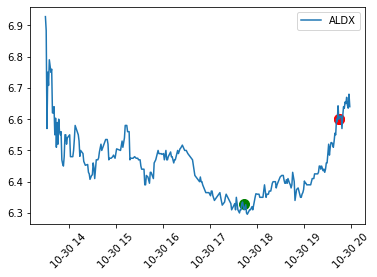

ASTC analysis with profit $9.99


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1998.00,-1998.00,buy,2020-10-30 11:23:20.857889-04:00,2.00,999,-4.53%,-2.83%,"{'buy': {'avg': 2.0357, 'macd': [-0.007807148182834567, -0.00877084863344324, -0.010290993807509086, -0.01134187324434599, -0.010974482243902628], 'vwap': 1.9985, 'reason': ['MACD signal'], 'macd_signal': [-0.002784986878605715, -0.00398215922957322, -0.005243926145160393, -0.006463515564997512, -0.007365708900778535]}, 'sell': None}",2.35,1.90
1,9.99,2007.99,sell,2020-10-30 15:39:17.830928-04:00,2.01,999,-4.05%,,"{'buy': None, 'sell': {'avg': 2.0079, 'rsi': [48.571362553448175, 52.46104491407699, 53.52864167492788], 'vwap': 2.01, 'reasons': 'bail post whipsawed', 'movement': 0.004999999999999893, 'sell_macd': [0.005806306773033398, 0.0051734629986119884, 0.00409366962895108, 0.0036043024626053466, 0.0032904539893148232], 'sell_macd_signal': [0.005989081534808647, 0.005825957827569316, 0.005479500187845669, 0.005104460642797604, 0.004741659312101048]}}",2.35,1.90


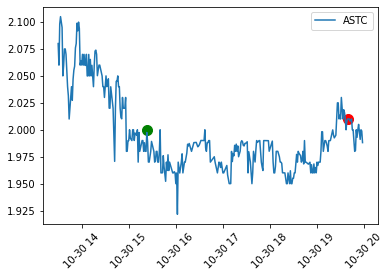

CHX analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2839.98,-2839.98,buy,2020-10-30 10:38:20.129332-04:00,8.58,331,2.75%,0.97%,"{'buy': {'avg': 8.4306, 'macd': [-0.007386671975970316, -0.008438045358952095, -0.00876675048397857, -0.003340331416874065, 0.003342365361248767], 'vwap': 8.58, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [-0.0018305084273828537, -0.0031520158136967022, -0.004274962747753076, -0.0040880364815772735, -0.0026019561130120653]}, 'sell': None}",9.48,8.28
1,0.00,2839.98,sell,2020-10-30 11:57:01.392001-04:00,8.58,331,2.75%,,"{'buy': None, 'sell': {'avg': 8.4717, 'rsi': [64.10337489668494, 45.968648255070846, 48.08577274773039], 'vwap': 8.585, 'reasons': 'bail post whipsawed', 'movement': 0.0005827505827506738, 'sell_macd': [0.010948932845721515, 0.012369907398008806, 0.012797031628389632, 0.009664959189356281, 0.007540422753884002], 'sell_macd_signal': [0.00673626093023876, 0.00786299022379277, 0.008849798504712143, 0.00901283064164097, 0.008718349064089578]}}",9.48,8.28


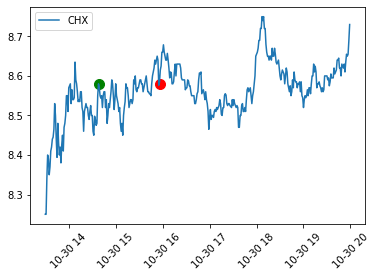

CVGI analysis with profit $-10.26


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1993.86,-1993.86,buy,2020-10-30 13:36:08.203823-04:00,5.83,342,1.04%,3.24%,"{'buy': {'avg': 5.9568, 'macd': [-0.010323018282090146, -0.013176572788444751, -0.016127698731208895, -0.01679964493685393, -0.016585581656357817], 'vwap': 5.84, 'reason': ['MACD signal'], 'macd_signal': [-0.00317171360965531, -0.005172685445413198, -0.007363688102572338, -0.009250879469428656, -0.010717819906814488]}, 'sell': None}",6.77,5.55
1,-10.26,1983.60,sell,2020-10-30 15:47:24.316024-04:00,5.80,342,0.52%,,"{'buy': None, 'sell': {'liquidation': 1}}",6.77,5.55


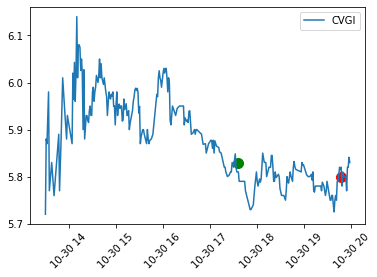

CYH analysis with profit $50.40


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1999.20,-1999.20,buy,2020-10-30 12:45:10.886336-04:00,5.95,336,-1.82%,-0.99%,"{'buy': {'avg': 6.0003, 'macd': [-0.004611678138441988, -0.008118245120587453, -0.011004943481731644, -0.011552955925718145, -0.011310459701217468], 'vwap': 5.95, 'reason': ['MACD signal'], 'macd_signal': [0.003033588232435448, 0.0008032215618308676, -0.001558411446881635, -0.003557320342648937, -0.005107948214362643]}, 'sell': None}",6.85,5.65
1,50.40,2049.60,sell,2020-10-30 15:45:10.742232-04:00,6.10,336,0.66%,,"{'buy': None, 'sell': {'liquidation': 1}}",6.85,5.65


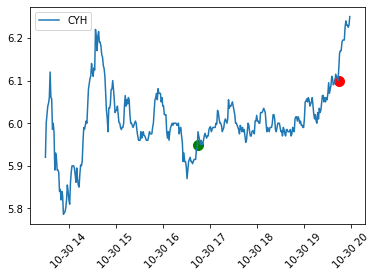

DSKE analysis with profit $-283.10


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,7928.32,7928.32,sell,2020-10-30 10:31:28.057890-04:00,6.08,1304,3.05%,,"{'buy': None, 'sell': {'avg': 6.1243, 'vwap': 6.0902, 'volume': [18760.0, 4238.0, 691.0, 14109.0, 1101.0], '5-min-close': [6.4506, 6.3, 6.2, 6.1, 6.0901], 'vwap_series': [6.115336024560269, 6.1657910453902725, 6.16910266448604, 6.168248414464965, 6.166931634655166]}}",5.86,6.17
1,-156.48,-8084.80,buy,2020-10-30 10:34:17.846493-04:00,6.20,1304,5.08%,,"{'buy': {'reason': 'stopped', 'close_5m': [6.4506, 6.3, 6.2, 6.1, 6.13]}, 'sell': None}",5.86,6.17
2,5745.96,5902.44,sell,2020-10-30 10:34:32.050961-04:00,6.06,974,2.71%,,"{'buy': None, 'sell': {'avg': 6.1216, 'vwap': 6.06, 'volume': [691.0, 14109.0, 29320.0, 12113.0, 800.0], '5-min-close': [6.4506, 6.3, 6.2, 6.1, 6.06], 'vwap_series': [6.115336024560269, 6.1657910453902725, 6.16910266448604, 6.168248414464965, 6.162702064301146]}}",5.75,6.16
3,-283.10,-6029.06,buy,2020-10-30 10:35:49.940036-04:00,6.19,974,4.92%,,"{'buy': {'reason': 'stopped', 'close_5m': [6.4506, 6.3, 6.2, 6.1, 6.13]}, 'sell': None}",5.75,6.16


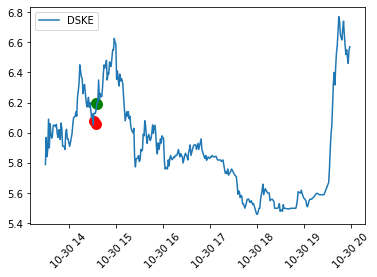

DSS analysis with profit $-58.94


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1995.54,-1995.54,buy,2020-10-30 13:48:23.860767-04:00,4.74,421,0.85%,3.56%,"{'buy': {'avg': 4.8675, 'macd': [-0.006203105772532247, -0.008643795971045698, -0.010230777996236284, -0.011022831808122469, -0.010457901897798827], 'vwap': 4.7384, 'reason': ['MACD signal'], 'macd_signal': [-0.005397659943872078, -0.006046887149306802, -0.006883665318692699, -0.0077114986165786525, -0.008260779272822687]}, 'sell': None}",5.50,4.50
1,-58.94,1936.60,sell,2020-10-30 15:45:56.579902-04:00,4.60,421,-2.13%,,"{'buy': None, 'sell': {'liquidation': 1}}",5.50,4.50


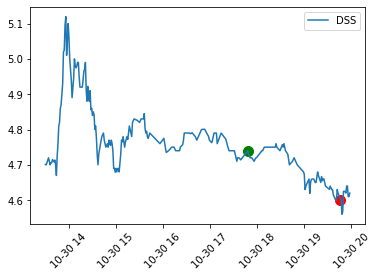

HCC analysis with profit $1.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1999.20,-1999.20,buy,2020-10-30 13:18:39.830185-04:00,14.70,136,0.75%,1.86%,"{'buy': {'avg': 14.8607, 'macd': [-0.017934588391447903, -0.026545085019010983, -0.03420852284543585, -0.0415539481277758, -0.041023708761706246], 'vwap': 14.7, 'reason': ['MACD signal'], 'macd_signal': [0.015995154123484075, 0.007487106294985063, -0.0008520195330991211, -0.008992405252034456, -0.015398665953968814]}, 'sell': None}",16.92,13.96
1,-381.10,1618.10,sell,2020-10-30 14:28:45.919195-04:00,14.71,110,0.82%,,"{'buy': None, 'sell': {'avg': 14.8298, 'rsi': [45.40443178924946, 44.1963592913214, 44.984555007806435], 'vwap': 14.705, 'reasons': 'bail post whipsawed', 'movement': 0.0003401360544218219, 'sell_macd': [0.005309510626712921, 0.002117730803107065, -0.0003968733555872461, -0.0028706314876156824, -0.0045012140387061805], 'sell_macd_signal': [0.014137427779672607, 0.0117334883843595, 0.00930741603637015, 0.006871806531572984, 0.004597202417517151]}}",16.92,13.96
2,1.36,382.46,sell,2020-10-30 14:28:46.091901-04:00,14.71,26,0.82%,,"{'buy': None, 'sell': {'avg': 14.8298, 'rsi': [45.40443178924946, 44.1963592913214, 44.984555007806435], 'vwap': 14.705, 'reasons': 'bail post whipsawed', 'movement': 0.0003401360544218219, 'sell_macd': [0.005309510626712921, 0.002117730803107065, -0.0003968733555872461, -0.0028706314876156824, -0.0045012140387061805], 'sell_macd_signal': [0.014137427779672607, 0.0117334883843595, 0.00930741603637015, 0.006871806531572984, 0.004597202417517151]}}",16.92,13.96


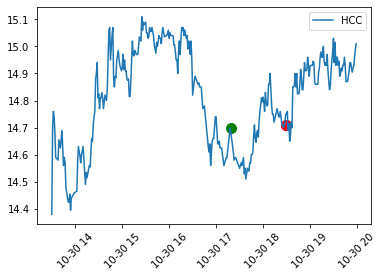

IMO analysis with profit $2.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3232.50,-3232.50,buy,2020-10-30 10:40:30.349613-04:00,12.93,250,1.81%,1.03%,"{'buy': {'avg': 12.8306, 'macd': [-0.03164752973034446, -0.031057722038891455, -0.02665194425169659, -0.02010437539561316, -0.01314996246967226], 'vwap': 12.9137, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.022442142142884838, -0.024165258122086163, -0.02466259534800825, -0.02375095135752923, -0.021630753579957838]}, 'sell': None}",14.12,12.53
1,2.50,3235.00,sell,2020-10-30 11:38:50.243769-04:00,12.94,250,1.89%,,"{'buy': None, 'sell': {'avg': 12.8448, 'rsi': [65.74057245774735, 58.502476205235496, 55.22826307933403], 'vwap': 12.94, 'reasons': 'bail post whipsawed', 'movement': 0.0007733952049497129, 'sell_macd': [0.0074510862745924555, 0.007756406583220965, 0.009192287257695497, 0.009152813922769454, 0.008483707247208372], 'sell_macd_signal': [0.009354128775059149, 0.009034584336691511, 0.009066124920892309, 0.009083462721267737, 0.008963511626455863]}}",14.12,12.53


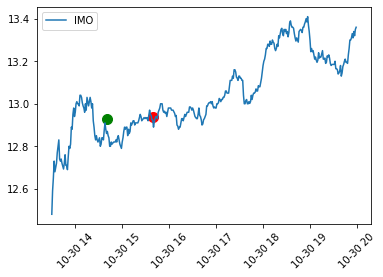

MGI analysis with profit $-46.56


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1994.32,-1994.32,buy,2020-10-30 12:55:37.758737-04:00,5.14,388,-4.1%,2.89%,"{'buy': {'avg': 5.5149, 'macd': [-0.0099869575359266, -0.015536934120018664, -0.01628318945671392, -0.017432437907947573, -0.017369093351662812], 'vwap': 5.1421, 'reason': ['MACD signal'], 'macd_signal': [0.008810809428478608, 0.003941260718779153, -0.00010362931631946199, -0.0035693910346450844, -0.006329331498048631]}, 'sell': None}",5.93,4.89
1,-46.56,1947.76,sell,2020-10-30 15:45:14.575487-04:00,5.02,388,-6.34%,,"{'buy': None, 'sell': {'liquidation': 1}}",5.93,4.89


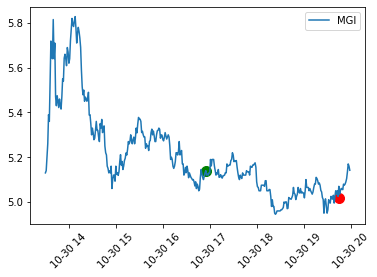

MX analysis with profit $-31.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1992.26,-1992.26,buy,2020-10-30 13:29:27.705439-04:00,14.03,142,-2.84%,-1.46%,"{'buy': {'avg': 14.2298, 'macd': [-0.019833102688014748, -0.02486949908893088, -0.03158786642615219, -0.03329584270936081, -0.028480034063687043], 'vwap': 14.03, 'reason': ['MACD signal'], 'macd_signal': [-0.010759921983118042, -0.01358183740428061, -0.017183043208654925, -0.020405603108796102, -0.02202048929977429]}, 'sell': None}",16.15,13.33
1,-31.24,1961.02,sell,2020-10-30 15:00:52.846372-04:00,13.81,142,-4.36%,,"{'buy': None, 'sell': {'avg': 14.156, 'rsi': [70.48391780534254, 74.95475956307445, 82.46374704165119], 'vwap': 13.905, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.008909479686386316, 'sell_macd': [0.023845753679539783, 0.024304334634623004, 0.025384990773199334, 0.02797530736464715, 0.03508496565194896], 'sell_macd_signal': [0.018418818372864968, 0.019595921625216575, 0.020753735454813127, 0.02219804983677993, 0.02477543299981374]}}",16.15,13.33


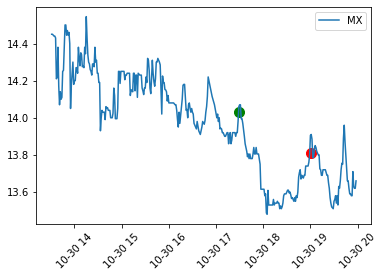

NCMI analysis with profit $21.12


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1995.84,-1995.84,buy,2020-10-30 11:38:49.897706-04:00,1.89,1056,-6.44%,-1.4%,"{'buy': {'avg': 1.9917, 'macd': [-0.01089066414616413, -0.0118730739136228, -0.013783093551725356, -0.014313198548276285, -0.014020901161845067], 'vwap': 1.8824, 'reason': ['MACD signal'], 'macd_signal': [-0.0040239219152647145, -0.005593752314936332, -0.007231620562294137, -0.008647936159490567, -0.009722529159961467]}, 'sell': None}",2.22,1.80
1,21.12,2016.96,sell,2020-10-30 12:19:20.782619-04:00,1.91,1056,-5.45%,,"{'buy': None, 'sell': {'avg': 1.9874, 'rsi': [61.30884831704997, 51.1873586243118, 51.187358624311805], 'vwap': 1.915, 'reasons': 'bail', 'movement': 0.013227513227513298, 'sell_macd': [0.005954556297564917, 0.005659161264982782, 0.00535548771667238, 0.00452982666972046, 0.003827625507553778], 'sell_macd_signal': [0.005227212154458159, 0.005313601976563083, 0.005321979124584942, 0.005163548633612046, 0.004896364008400393]}}",2.22,1.80


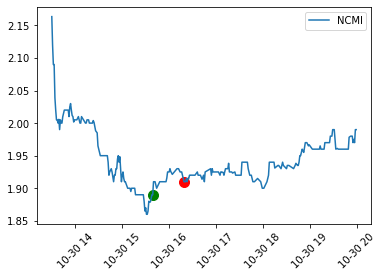

OCUL analysis with profit $63.30


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1989.73,-1989.73,buy,2020-10-30 11:07:45.491744-04:00,9.43,211,-4.17%,-2.09%,"{'buy': {'avg': 9.6342, 'macd': [-0.022663328248725634, -0.02445695149823024, -0.028913580634229774, -0.030192595796901145, -0.03001789857564674], 'vwap': 9.4446, 'reason': ['MACD signal'], 'macd_signal': [-0.00647643335802817, -0.010072536986068584, -0.013840745715700823, -0.017111115731940886, -0.019692472300682058]}, 'sell': None}",10.94,8.97
1,63.30,2053.03,sell,2020-10-30 12:19:46.725047-04:00,9.73,211,-1.12%,,"{'buy': None, 'sell': {'avg': 9.5972, 'rsi': [73.75782349012773, 77.52885227277172, 79.32831586945929], 'vwap': 9.73, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.03181336161187706, 'sell_macd': [0.022674257575367562, 0.023118204131597153, 0.02524182217370452, 0.028563578801662715, 0.03190308294290567], 'sell_macd_signal': [0.017266937364354112, 0.01843719071780272, 0.01979811700898308, 0.021551209367519007, 0.02362158408259634]}}",10.94,8.97


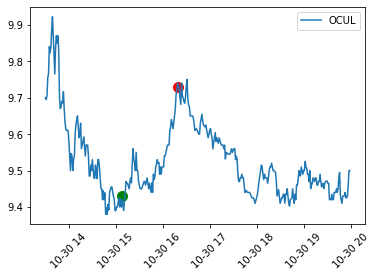

RYI analysis with profit $17.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1560.60,-1560.60,buy,2020-10-30 10:55:56.573633-04:00,8.67,180,4.72%,8.76%,"{'buy': {'avg': 9.0046, 'macd': [-0.14803006203604951, -0.14033650027783828, -0.1327095045951623, -0.11884778997659673, -0.1066330814865335], 'vwap': 8.6799, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.12552605770462522, -0.12848814621926782, -0.12933241789444672, -0.12723549231087672, -0.12311501014600808]}, 'sell': None}",10.34,8.13
1,37.80,1598.40,sell,2020-10-30 11:24:16.653394-04:00,8.88,180,7.26%,,"{'buy': None, 'sell': {'avg': 8.9881, 'rsi': [54.864898889870815, 55.54471207553131, 54.592551292981184], 'vwap': 8.9503, 'reasons': 'bail', 'movement': 0.03229527104959624, 'sell_macd': [0.04287294465611602, 0.039475933274687236, 0.03631623696091424, 0.03386561337926253, 0.031012327297725406], 'sell_macd_signal': [0.03016734222408879, 0.03202906043420848, 0.03288649573954963, 0.03308231926749221, 0.032668320873538846]}}",10.34,8.13
2,-1960.16,-1997.96,buy,2020-10-30 13:23:01.634335-04:00,7.96,251,-3.86%,7.38%,"{'buy': {'avg': 8.8907, 'macd': [-0.10006286234528261, -0.11139287997924008, -0.11409947969428202, -0.11835787583984292, -0.11754678353976367], 'vwap': 7.96, 'reason': ['MACD signal'], 'macd_signal': [-0.07055995862602818, -0.07872654289667055, -0.08580113025619285, -0.09231247937292286, -0.09735934020629103]}, 'sell': None}",9.82,7.56
3,-407.80,1552.36,sell,2020-10-30 15:45:33.656510-04:00,7.88,197,-4.82%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.82,7.56
4,-242.32,165.48,sell,2020-10-30 15:45:33.834561-04:00,7.88,21,-4.82%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.82,7.56
5,17.72,260.04,sell,2020-10-30 15:45:33.953293-04:00,7.88,33,-4.82%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.82,7.56


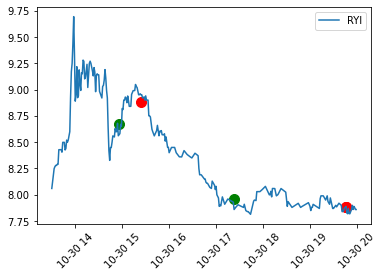

SAVE analysis with profit $47.56


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1994.04,-1994.04,buy,2020-10-30 12:48:33.718496-04:00,17.19,116,-3.48%,-2.19%,"{'buy': {'avg': 17.4205, 'macd': [-0.00787918591104031, -0.010744044642979844, -0.017771933984192856, -0.022497926535990587, -0.02225197363432585], 'vwap': 17.1894, 'reason': ['MACD signal'], 'macd_signal': [-0.001324253482303844, -0.0032082117144390443, -0.006120956168389807, -0.009396350241909962, -0.011967474920393139]}, 'sell': None}",19.85,16.33
1,47.56,2041.60,sell,2020-10-30 14:11:08.850911-04:00,17.60,116,-1.18%,,"{'buy': None, 'sell': {'avg': 17.3936, 'rsi': [74.15419259546988, 71.93780558868555, 71.93780558868555], 'vwap': 17.6, 'reasons': 'bail', 'movement': 0.023851076207097158, 'sell_macd': [0.0708026161313029, 0.07025244517868146, 0.06904124125223987, 0.0665514558387521, 0.0637470586874791], 'sell_macd_signal': [0.06318027708577136, 0.06459471070435338, 0.06548401681393068, 0.06569750461889497, 0.06530741543261179]}}",19.85,16.33


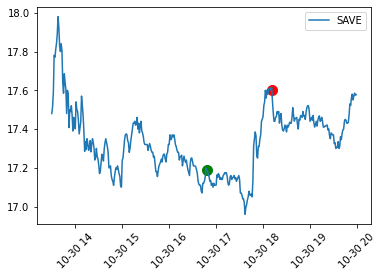

SQNS analysis with profit $14.61


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1996.70,-1996.70,buy,2020-10-30 13:05:09.327436-04:00,4.10,487,-2.15%,-1.15%,"{'buy': {'avg': 4.1418, 'macd': [-0.002444794817824558, -0.0012185432848834665, -0.0012757688009692458, -0.0013089864914128668, -0.0007931952568052125], 'vwap': 4.1, 'reason': ['MACD signal'], 'macd_signal': [-0.008829039785590995, -0.007306940485449489, -0.00610070614855344, -0.005142362217125326, -0.004272528825061303]}, 'sell': None}",4.73,3.89
1,14.61,2011.31,sell,2020-10-30 15:23:09.397438-04:00,4.13,487,-1.43%,,"{'buy': None, 'sell': {'avg': 4.1195, 'rsi': [65.55610130622317, 69.70219715375413, 80.04790504735124], 'vwap': 4.19, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.021951219512195305, 'sell_macd': [0.008575060558558611, 0.008455973838119135, 0.00825336114896924, 0.008507775142502894, 0.010673451304444193], 'sell_macd_signal': [0.007246648285190202, 0.007488513395775989, 0.007641482946414639, 0.00781474138563229, 0.008386483369394671]}}",4.73,3.89


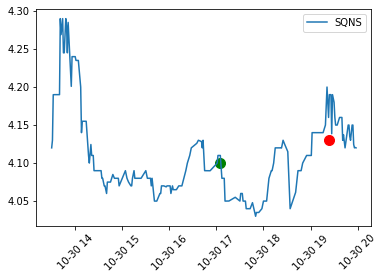

STKL analysis with profit $31.35


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1992.15,-1992.15,buy,2020-10-30 11:16:58.183798-04:00,6.99,285,-1.83%,0.05%,"{'buy': {'avg': 7.1237, 'macd': [0.0008310058561882272, -0.005604918030797101, -0.01158609355272322, -0.013498878458733543, -0.013255608535382102], 'vwap': 6.9629, 'reason': ['MACD signal'], 'macd_signal': [0.02037577739741583, 0.015179638311773245, 0.00982649193887395, 0.005161417859352452, 0.0014780125804055408]}, 'sell': None}",8.06,6.65
1,31.35,2023.50,sell,2020-10-30 11:58:37.320848-04:00,7.10,285,-0.28%,,"{'buy': None, 'sell': {'avg': 7.1186, 'rsi': [76.92583900111934, 78.96037178201425, 81.64453849157955], 'vwap': 7.1254, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.019370529327610835, 'sell_macd': [0.008402324682240447, 0.009759960580845828, 0.011210586468319406, 0.012714832790138964, 0.014521845082593465], 'sell_macd_signal': [0.007885589460485403, 0.008260463684557488, 0.008850488241309871, 0.00962335715107569, 0.010603054737379245]}}",8.06,6.65


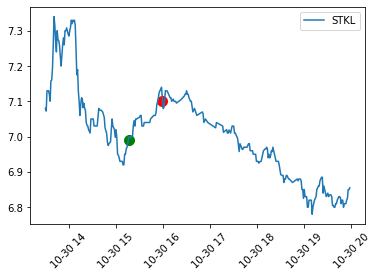

SUM analysis with profit $-5.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1991.06,-1991.06,buy,2020-10-30 13:41:23.850353-04:00,17.62,113,3.4%,3.61%,"{'buy': {'avg': 17.6546, 'macd': [-0.02209172915064883, -0.023881217844696323, -0.031458985426489505, -0.03383829801715521, -0.03343466759407576], 'vwap': 17.62, 'reason': ['MACD signal'], 'macd_signal': [0.00508112136239206, -0.0007113464790256176, -0.006860874268518395, -0.012256359018245759, -0.016492020733411758]}, 'sell': None}",20.32,16.74
1,-5.65,1985.41,sell,2020-10-30 15:45:10.702281-04:00,17.57,113,3.11%,,"{'buy': None, 'sell': {'liquidation': 1}}",20.32,16.74


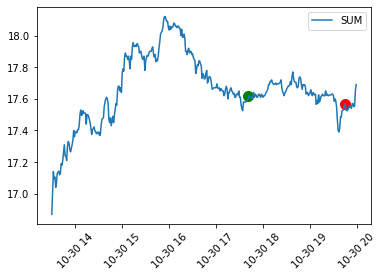

TCDA analysis with profit $19.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2342.40,-2342.40,buy,2020-10-30 10:51:11.083731-04:00,4.88,480,12.4%,10.13%,"{'buy': {'avg': 4.7817, 'macd': [-0.020763748612236732, -0.020415841114273192, -0.019583539329665278, -0.018636481927711834, -0.01688438302956996], 'vwap': 4.88, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.018912058489507742, -0.019212815014460833, -0.019286959877501723, -0.019156864287543745, -0.018702368035948987]}, 'sell': None}",5.50,4.67
1,19.20,2361.60,sell,2020-10-30 11:08:05.647779-04:00,4.92,480,13.32%,,"{'buy': None, 'sell': {'avg': 4.8092, 'rsi': [54.116573110002264, 54.11657311000225, 54.862446300156876], 'vwap': 4.9893, 'reasons': 'bail', 'movement': 0.022540983606557444, 'sell_macd': [0.016135170381590846, 0.015311003093096076, 0.014210210360592335, 0.013167901603309495, 0.01240807787551379], 'sell_macd_signal': [0.011968898677340736, 0.012637319560491803, 0.01295189772051191, 0.012995098497071426, 0.012877694372759898]}}",5.50,4.67


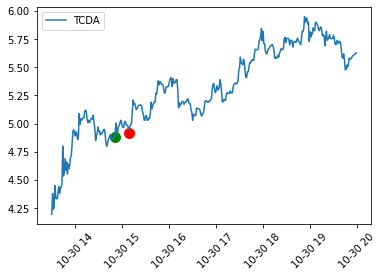

TILE analysis with profit $-92.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1987.20,-1987.20,buy,2020-10-30 11:28:09.701291-04:00,6.21,320,-5.19%,-1.22%,"{'buy': {'avg': 6.4702, 'macd': [-0.0228258769196108, -0.022639418330716587, -0.02479751010130915, -0.027196055505649852, -0.027153414840127787], 'vwap': 6.24, 'reason': ['MACD signal'], 'macd_signal': [-0.005528600517609572, -0.008950764080230975, -0.01212011328444661, -0.015135301728687258, -0.017538924350975364]}, 'sell': None}",7.22,5.93
1,-92.80,1894.40,sell,2020-10-30 15:07:56.932437-04:00,5.92,320,-9.62%,,"{'buy': None, 'sell': {'avg': 6.3358, 'rsi': [29.208602984290593, 34.71208342872231, 26.003711660266], 'vwap': 5.92, 'reasons': 'stopped', 'movement': -0.046698872785829314, 'sell_macd': [-0.005686706003055875, -0.007613116664487052, -0.00901534423619399, -0.009471426185105436, -0.011781731259775441], 'sell_macd_signal': [-0.005659041069047242, -0.006049856188135204, -0.0066429537977469606, -0.007208648275218656, -0.008123264872130012]}}",7.22,5.93


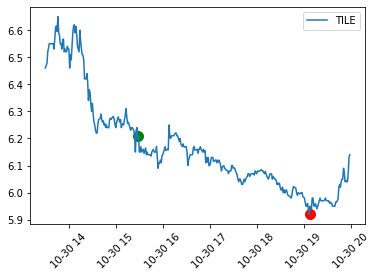

UA analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1991.86,-1991.86,buy,2020-10-30 11:18:17.822787-04:00,12.22,163,-6.37%,-2.5%,"{'buy': {'avg': 12.7241, 'macd': [-0.007210144363893889, -0.020526650505996002, -0.038439166324439, -0.04774711155537581, -0.047621521974866354], 'vwap': 12.2074, 'reason': ['MACD signal'], 'macd_signal': [0.04280559830325023, 0.030139148541400984, 0.016423485568232987, 0.0035893661435112256, -0.006652811480164292]}, 'sell': None}",14.10,11.61
1,0.00,1991.86,sell,2020-10-30 13:42:38.718020-04:00,12.22,163,-6.37%,,"{'buy': None, 'sell': {'avg': 12.552, 'rsi': [63.9766303618589, 60.424105857489444, 62.65720121180433], 'vwap': 12.2214, 'reasons': 'bail post whipsawed', 'movement': 0.00040916530278224265, 'sell_macd': [0.020968702651432025, 0.020958066320758917, 0.019903569617365946, 0.018303915437874352, 0.017152186006610393], 'sell_macd_signal': [0.020103073804841737, 0.020274072308025172, 0.020199971769893327, 0.01982076050348953, 0.019287045604113703]}}",14.10,11.61


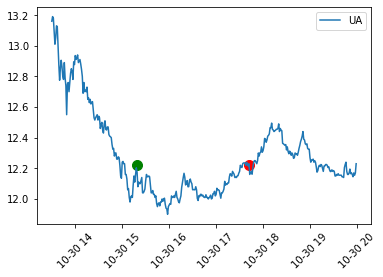

UAA analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1987.70,-1987.70,buy,2020-10-30 11:18:20.717022-04:00,13.90,143,-6.9%,-2.78%,"{'buy': {'avg': 14.5149, 'macd': [-0.0178483801951117, -0.032822282893004484, -0.054193865736907654, -0.06451725670959796, -0.06410279179598533], 'vwap': 13.9088, 'reason': ['MACD signal'], 'macd_signal': [0.04046486201183302, 0.025807433030865516, 0.009807173277310881, -0.005057712720070887, -0.016866728535253776]}, 'sell': None}",16.08,13.21
1,-472.60,1515.10,sell,2020-10-30 13:40:59.775738-04:00,13.90,109,-6.9%,,"{'buy': None, 'sell': {'avg': 14.3231, 'rsi': [62.1116687568515, 66.96865692086244, 62.64452089397031], 'vwap': 13.905, 'reasons': 'bail post whipsawed', 'movement': 0.0003597122302157558, 'sell_macd': [0.024776343712362703, 0.025080857152184777, 0.023433973376041806, 0.023404791558579774, 0.02229887336888936], 'sell_macd_signal': [0.022230064825749837, 0.022800223291036825, 0.02292697330803782, 0.02302253695814621, 0.02287780424029484]}}",16.08,13.21
2,0.00,472.60,sell,2020-10-30 13:40:59.906857-04:00,13.90,34,-6.9%,,"{'buy': None, 'sell': {'avg': 14.3231, 'rsi': [62.1116687568515, 66.96865692086244, 62.64452089397031], 'vwap': 13.905, 'reasons': 'bail post whipsawed', 'movement': 0.0003597122302157558, 'sell_macd': [0.024776343712362703, 0.025080857152184777, 0.023433973376041806, 0.023404791558579774, 0.02229887336888936], 'sell_macd_signal': [0.022230064825749837, 0.022800223291036825, 0.02292697330803782, 0.02302253695814621, 0.02287780424029484]}}",16.08,13.21


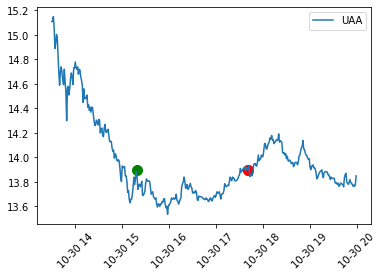

UVE analysis with profit $58.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1993.49,-1993.49,buy,2020-10-30 11:56:36.757961-04:00,12.23,163,-2.78%,-1.2%,"{'buy': {'avg': 12.429, 'macd': [-0.00915805231064759, -0.01193948661574673, -0.016029701832501075, -0.019008704575005808, -0.018485736522737994], 'vwap': 12.2556, 'reason': ['MACD signal'], 'macd_signal': [0.012471416379458478, 0.007589235780417435, 0.002865448257833733, -0.0015093823087341755, -0.004904653151534939]}, 'sell': None}",14.14,11.64
1,58.68,2052.17,sell,2020-10-30 13:45:38.815810-04:00,12.59,163,0.08%,,"{'buy': None, 'sell': {'avg': 12.4073, 'rsi': [75.59610427443317, 75.59610427443317, 79.58460833079113], 'vwap': 12.6, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.030253475061324548, 'sell_macd': [0.023693535011656053, 0.025007910553799917, 0.02700602252749995, 0.02821226533132304, 0.03086372381051916], 'sell_macd_signal': [0.017632041997459196, 0.01910721570872734, 0.020686977072481863, 0.022192034724250097, 0.02392637254150391]}}",14.14,11.64


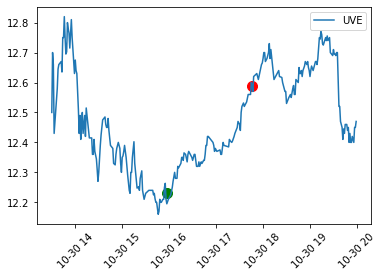

In [6]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(
        hour=9, minute=30, second=0, microsecond=0, tzinfo=None
    )
    end_date = start_date.replace(hour=16, minute=0, tzinfo=None)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        start_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
        end_index = minute_history[symbol]["close"].index.get_loc(
            end_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = float(minute_history[symbol]["close"][cool_minute_history_index])
    plt.plot(
        minute_history[symbol]["close"][start_index:end_index],
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    for index, row in symbol_df.iterrows():

        try:
            now = int(row["client_time"])
            continue
        except Exception:
            pass

        delta = (
            row["price"]
            * row["qty"]
            * (1 if row["operation"] == "sell" and row["qty"] > 0 else -1)
        )

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if indicator["buy"] and "avg" in indicator["buy"]
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()